<a href="https://www.kaggle.com/code/aisuko/zero-shot-object-detection?scriptVersionId=164811787" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Overview

Traditionally, models used for [object detection](https://www.kaggle.com/code/aisuko/object-detection) require labeled image datasets for training, and are limited to detecting the set of classes from the training data. Zero-shot object detection is supported by the OWL-ViT model which uses a different approach. OWL-ViT is an open-vocabulary object detector. It means that it can detect objects in images based on free-text queries without the need to fine-tune the model on labeled datasets. OWL-ViT leverages multi-modal representations to perform open-vocabulary detection. It combines [CLIP](https://huggingface.co/docs/transformers/model_doc/clip) with lightweight object classification and localization heads. **Open-vocabulary detection is achieved by embedding free-text queries with the text encoder of CLIP and using them as input to the object classification and localization heads;associate images and their corresponding textual descriptions, and ViT processes image patches as inputs.** The authors of OWL-ViT first trained CLIP from scratch and then fine-tuned OWL-ViT end to end on standard object detection datasets using a bipartite matching loss. With this apporach, the model can detect objects based on textual descriptions without prior training on labeled datasets.

Here we will use OWL-ViT:
- Detection objects based on text prompts
- For batch object detection
- For image-guided object detection

In [1]:
%%capture
!pip install transformers==4.35.2

# Zero-Shot Object Detection Pipeline

In [2]:
from transformers import pipeline

model_checkpoint="google/owlvit-base-patch32"
detector=pipeline(model=model_checkpoint, task="zero-shot-object-detection", device='cuda')
print(detector.device)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


config.json:   0%|          | 0.00/4.42k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/613M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


cuda


# Loading Image

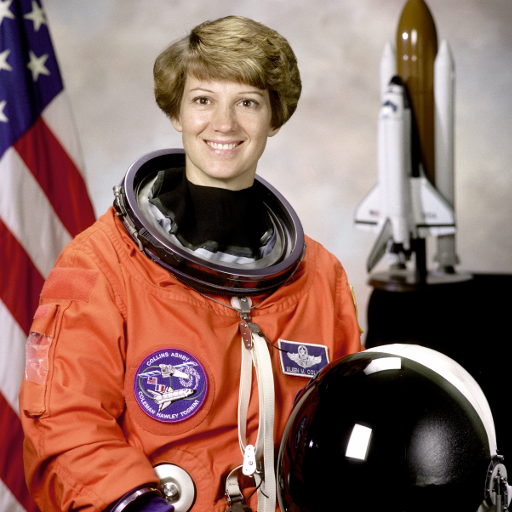

In [3]:
import skimage
import numpy as np
from PIL import Image

image=skimage.data.astronaut()
image=Image.fromarray(np.uint8(image)).convert("RGB")
image

Pass the image and the candidate object labels to look for the pipeline. Here we pass the image directly; other suitable options include a local path to an image or an image url. We also pass text descriptions for all items we want to query the image for.

In [4]:
predictions=detector(image, candidate_labels=["human face", "rocket", "nasa badge", "star-spangled banner"],)
predictions

[{'score': 0.357135534286499,
  'label': 'human face',
  'box': {'xmin': 180, 'ymin': 71, 'xmax': 271, 'ymax': 178}},
 {'score': 0.28099876642227173,
  'label': 'nasa badge',
  'box': {'xmin': 129, 'ymin': 348, 'xmax': 206, 'ymax': 427}},
 {'score': 0.21102316677570343,
  'label': 'rocket',
  'box': {'xmin': 350, 'ymin': -1, 'xmax': 468, 'ymax': 288}},
 {'score': 0.1379047930240631,
  'label': 'star-spangled banner',
  'box': {'xmin': 1, 'ymin': 1, 'xmax': 105, 'ymax': 509}},
 {'score': 0.11950060725212097,
  'label': 'nasa badge',
  'box': {'xmin': 277, 'ymin': 338, 'xmax': 327, 'ymax': 380}},
 {'score': 0.10649276524782181,
  'label': 'rocket',
  'box': {'xmin': 358, 'ymin': 64, 'xmax': 424, 'ymax': 280}}]

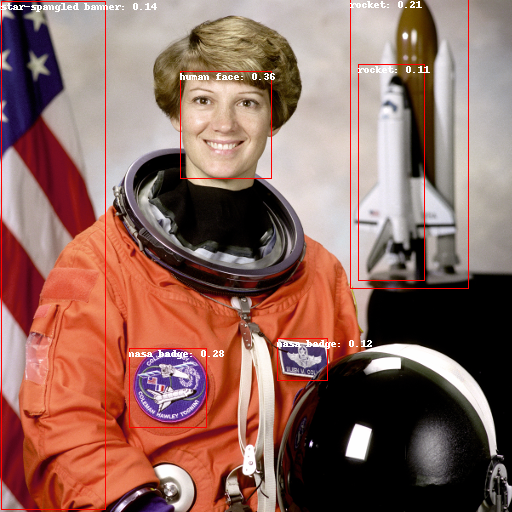

In [5]:
from PIL import ImageDraw

draw=ImageDraw.Draw(image)

for prediction in predictions:
    box=prediction["box"]
    label=prediction["label"]
    score=prediction["score"]
    
    xmin,ymin, xmax,ymax=box.values()
    draw.rectangle((xmin, ymin, xmax, ymax), outline="red", width=1)
    draw.text((xmin,ymin), f"{label}: {round(score,2)}", fill="white")

image

# Text-prompted Zero-Shot Object Detection

In [6]:
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection

model=AutoModelForZeroShotObjectDetection.from_pretrained(model_checkpoint)
processor=AutoProcessor.from_pretrained(model_checkpoint)

In [7]:
import requests

url="https://unsplash.com/photos/oj0zeY2Ltk4/download?ixid=MnwxMjA3fDB8MXxzZWFyY2h8MTR8fHBpY25pY3xlbnwwfHx8fDE2Nzc0OTE1NDk&force=true&w=640"
im=Image.open(requests.get(url, stream=True).raw)
text_queries=["hat", "book", "sunglasses", "camera"]
inputs=processor(text=text_queries, images=im, return_tensors="pt")
print(input)

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x7e2751208ca0>>


# Resize Image to Fit Model

We will need to resize the images before feeding them to the model by using the `post_process_object_detection()` to make sure the predicted bounding boxes have the correct coordinates relative to the orignal image:

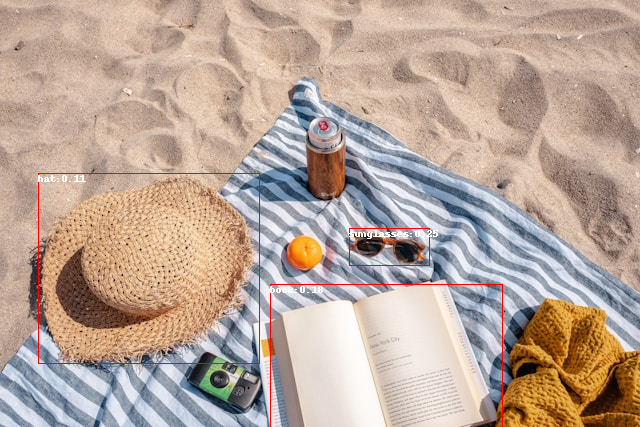

In [8]:
import torch

with torch.no_grad():
    outputs=model(**inputs)
    target_sizes=torch.tensor([im.size[::-1]])
    results=processor.post_process_object_detection(outputs, threshold=0.1, target_sizes=target_sizes)[0]

draw=ImageDraw.Draw(im)

scores=results["scores"].tolist()
labels=results["labels"].tolist()
boxes=results["boxes"].tolist()

for box, score, label in zip(boxes, scores, labels):
    xmin, ymin, xmax,ymax=box
    draw.rectangle((xmin, ymin,xmax, ymax), outline="red", width=1)
    draw.text((xmin,ymin), f"{text_queries[label]}:{round(score,2)}", fill="white")

im

# Batch Processing

We can pass multiple sets of images and text queries to search for different(or same) objects in several images. Let's use astronaut image and the beach image together. For batch processing, we should pass text queries as a nested list to the processor and images as list of PIL images, PyTorch tensors, or NumPy arrays.

In [9]:
im_batch=Image.open(requests.get(url, stream=True).raw)

images=[image, im_batch]

text_queries=[
    ["human face", "rocket", "nasa badge","start-spangled banner"],
    ["hat","book","sunglasses", "camera"],
]

inputs=processor(text=text_queries, images=images, return_tensors="pt")
print(inputs)

{'input_ids': tensor([[49406,  2751,  1710, 49407,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0],
        [49406,  8383, 49407,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0],
        [49406,  6841, 11301, 49407,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0],
        [49406,  1572,   268,   588, 32322,  9185, 49407,     0,     0,     0,
             0,     0,     0,     0,     0,     0],
        [49406,  3801, 49407,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0],
        [49406,  1116, 49407,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0],
        [49406, 12906, 49407,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0],
        [49406,  3934, 49407,     0,     0,     0,     0,     0,     

With several images, we can pass a tuples. Here we are going to create predictions for the two examples, and visualize the second one(image_idx=1).

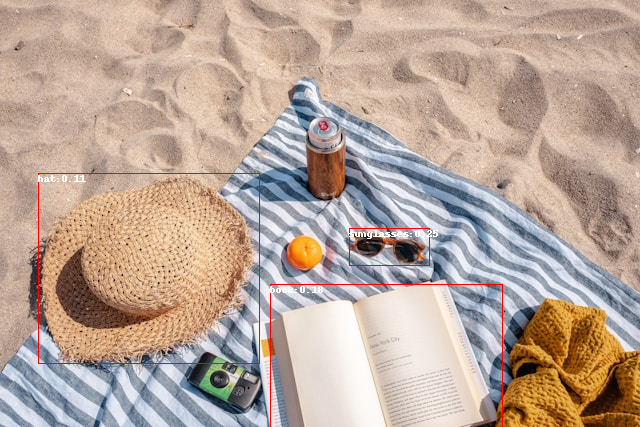

In [10]:
with torch.no_grad():
    outputs=model(**inputs)
    target_sizes=[x.size[::-1] for x in images]
    results=processor.post_process_object_detection(outputs, threshold=0.1, target_sizes=target_sizes)
    
image_idx=1
draw=ImageDraw.Draw(images[image_idx])

scores=results[image_idx]["scores"].tolist()
labels=results[image_idx]["labels"].tolist()
boxes=results[image_idx]["boxes"].tolist()

for box, score, label in zip(boxes, scores, labels):
    xmin, ymin, xmax, ymax=box
    draw.rectangle((xmin, ymin, xmax, ymax), outline="red", width=1)
    draw.text((xmin, ymin), f"{text_queries[image_idx][label]}:{round(score,2)}", fill="white")

images[image_idx]

# Image-Guided Object Detection

It means we can use an image query to find similar objects in the target image, and an image of a single cat as a query:

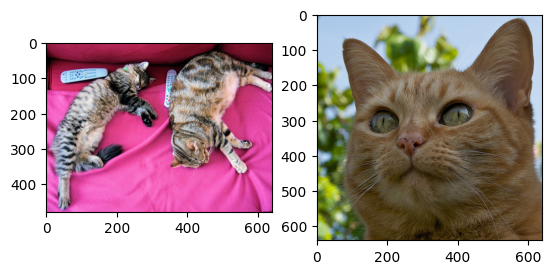

In [11]:
import matplotlib.pyplot as plt


url="http://images.cocodataset.org/val2017/000000039769.jpg"
image_target=Image.open(requests.get(url, stream=True).raw)

query_url="http://images.cocodataset.org/val2017/000000524280.jpg"
query_image=Image.open(requests.get(query_url, stream=True).raw)

# Take a quick look at the images
fig, ax=plt.subplots(1,2)
ax[0].imshow(image_target)
ax[1].imshow(query_image)

In [12]:
inputs=processor(images=image_target, query_images=query_image, return_tensors="pt")
print(inputs)

{'query_pixel_values': tensor([[[[-0.7850, -0.7120, -0.6098,  ...,  1.0106,  1.0106,  1.0106],
          [-0.7704, -0.6828, -0.5806,  ...,  1.0106,  1.0106,  1.0106],
          [-0.7704, -0.6974, -0.5952,  ...,  1.0106,  1.0106,  1.0106],
          ...,
          [-0.4930, -0.4930, -0.5222,  ...,  0.2077,  0.2077,  0.2223],
          [-0.4638, -0.4930, -0.4930,  ...,  0.1055,  0.0617,  0.0325],
          [-0.4492, -0.4784, -0.4784,  ...,  0.0179,  0.1055,  0.2661]],

         [[-0.1613, -0.1012, -0.0412,  ...,  1.4596,  1.4596,  1.4596],
          [-0.1313, -0.0862, -0.0112,  ...,  1.4596,  1.4596,  1.4596],
          [-0.1463, -0.1012, -0.0112,  ...,  1.4596,  1.4596,  1.4596],
          ...,
          [-0.1913, -0.1463, -0.1763,  ..., -0.1463, -0.1463, -0.1313],
          [-0.1763, -0.1613, -0.1463,  ..., -0.2363, -0.2963, -0.3264],
          [-0.1613, -0.1613, -0.1163,  ..., -0.3414, -0.2513, -0.0862]],

         [[-0.7550, -0.5275, -0.2146,  ...,  1.9042,  1.9042,  1.9042],
       

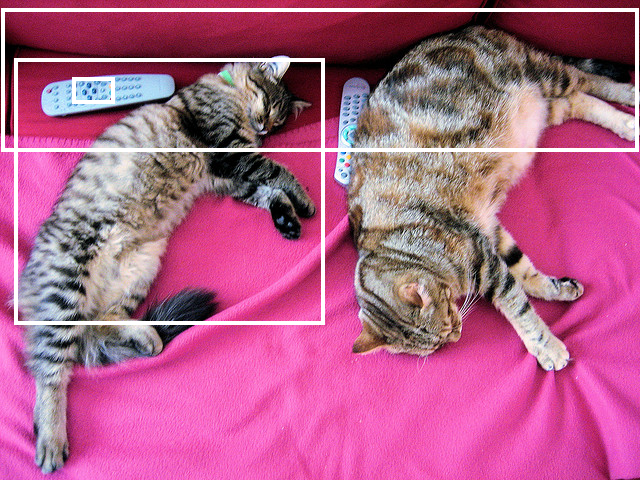

In [13]:
with torch.no_grad():
    outputs=model.image_guided_detection(**inputs)
    target_sizes=torch.tensor([image_target.size[::-1]])
    results=processor.post_process_image_guided_detection(outputs=outputs, target_sizes=target_sizes)[0]

draw=ImageDraw.Draw(image_target)

scores=results["scores"].tolist()
boxes=results["boxes"].tolist()

for box, score, label in zip(boxes, scores, labels):
    xmin, ymin, xmax, ymax=box
    draw.rectangle((xmin, ymin, xmax, ymax), outline="white", width=4)

image_target